In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

In [171]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


df = pd.read_csv('./datasets/diabetes.csv')
df.columns = df.columns.str.upper()

# Explanatory Data Analysis

### Big Picture

In [172]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
PREGNANCIES                   int64
GLUCOSE                       int64
BLOODPRESSURE                 int64
SKINTHICKNESS                 int64
INSULIN                       int64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                           int64
OUTCOME                       int64
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 2

### Numerical and Categorical Variables

In [173]:
def grab_columns(df,cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtype not in [int, float]]
    num_cols = [col for col in df.columns if df[col].dtype in [int, float]]
    num_but_cat = [col for col in df.columns if df[col].dtype in [int,float] and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtype in ["object", "category", "bool"] and df[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_columns(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


### Analysis of Categorical Variables

         OUTCOME  Ratio
OUTCOME                
0            500 65.104
1            268 34.896
##########################################


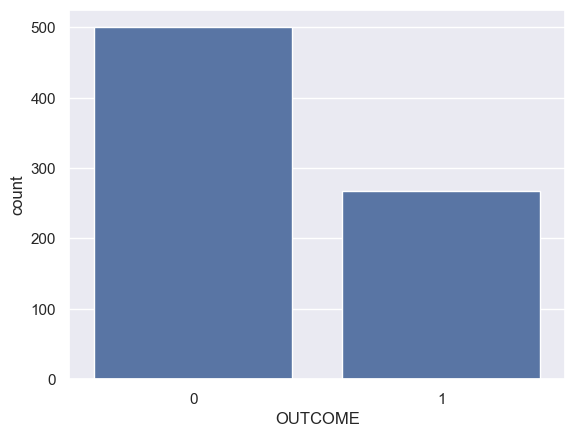

In [174]:
def cat_summary(df,col_name,plot=True):
    print(pd.DataFrame({
        col_name:df[col_name].value_counts(),
        'Ratio': 100*(df[col_name].value_counts())/len(df)
    }))
    print("##########################################")

    if plot:
        sns.countplot(x=df[col_name], data=df)
        plt.show


cat_summary(df,"OUTCOME")



### Analysis of Numerical Values

                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI                      768.000  31.993   7.884  0.000 21

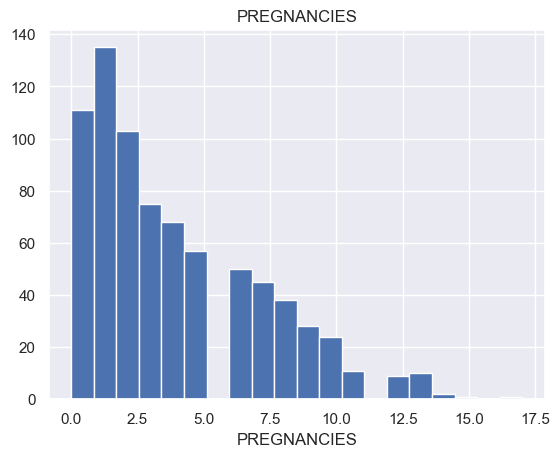

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

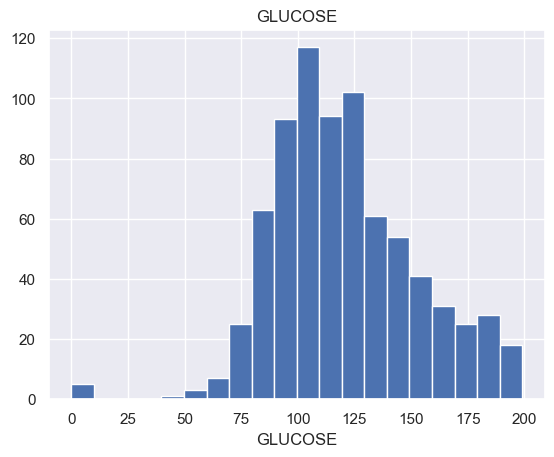

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

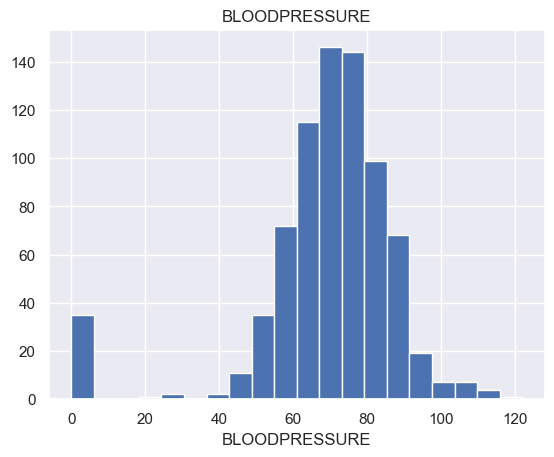

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

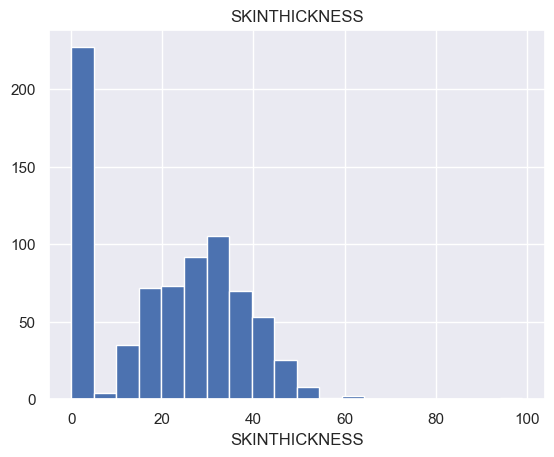

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

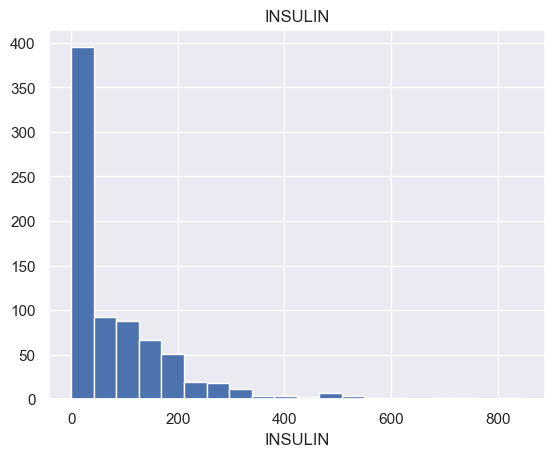

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

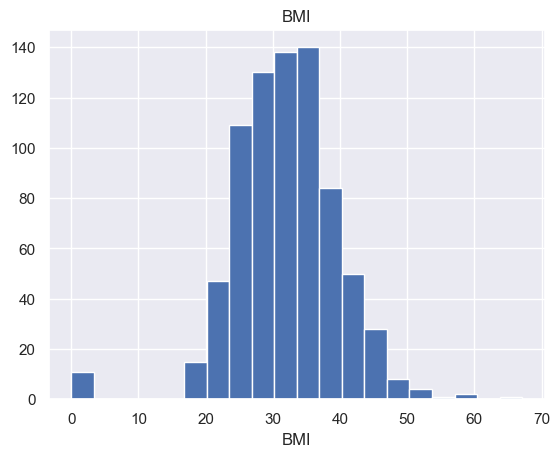

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

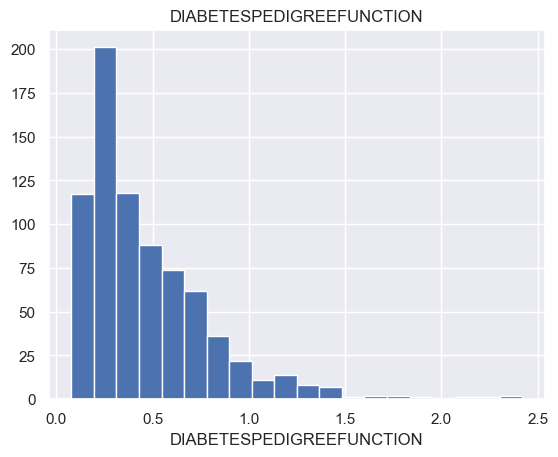

**************************************************
                           count    mean     std    min     5%    10%    20%     30%     40%     50%     60%     70%     80%     90%     95%     99%     max
PREGNANCIES              768.000   3.845   3.370  0.000  0.000  0.000  1.000   1.000   2.000   3.000   4.000   5.000   7.000   9.000  10.000  13.000  17.000
GLUCOSE                  768.000 120.895  31.973  0.000 79.000 85.000 95.000 102.000 109.000 117.000 125.000 134.000 147.000 167.000 181.000 196.000 199.000
BLOODPRESSURE            768.000  69.105  19.356  0.000 38.700 54.000 60.000  64.000  68.000  72.000  74.000  78.000  82.000  88.000  90.000 106.000 122.000
SKINTHICKNESS            768.000  20.536  15.952  0.000  0.000  0.000  0.000   8.200  18.000  23.000  27.000  31.000  35.000  40.000  44.000  51.330  99.000
INSULIN                  768.000  79.799 115.244  0.000  0.000  0.000  0.000   0.000   0.000  30.500  72.200 106.000 150.000 210.000 293.000 519.900 846.000
BMI    

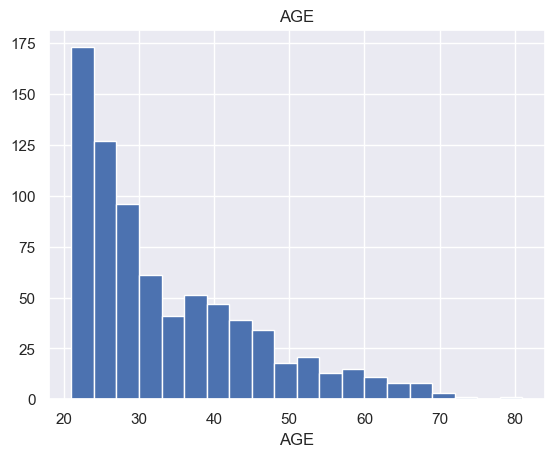

**************************************************


In [175]:
def num_summary(df,numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(df.describe(quantiles).T)

    if plot:
        df[numerical_col].hist(bins=20)
        plt.xlabel(f"{numerical_col}")
        plt.title(f"{numerical_col}")
        plt.show(block=True)

for col in num_cols:
    num_summary(df,col, True)
    print("*"*50)
    


### Numerical Variables Analysis according to Target Variable

In [176]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: ["mean", "count"]}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "OUTCOME", col)

        PREGNANCIES      
               mean count
OUTCOME                  
0             3.298   500
1             4.866   268


        GLUCOSE      
           mean count
OUTCOME              
0       109.980   500
1       141.257   268


        BLOODPRESSURE      
                 mean count
OUTCOME                    
0              68.184   500
1              70.825   268


        SKINTHICKNESS      
                 mean count
OUTCOME                    
0              19.664   500
1              22.164   268


        INSULIN      
           mean count
OUTCOME              
0        68.792   500
1       100.336   268


           BMI      
          mean count
OUTCOME             
0       30.304   500
1       35.143   268


        DIABETESPEDIGREEFUNCTION      
                            mean count
OUTCOME                               
0                          0.430   500
1                          0.550   268


           AGE      
          mean count
OUTCOME       

### Correlation Analysis

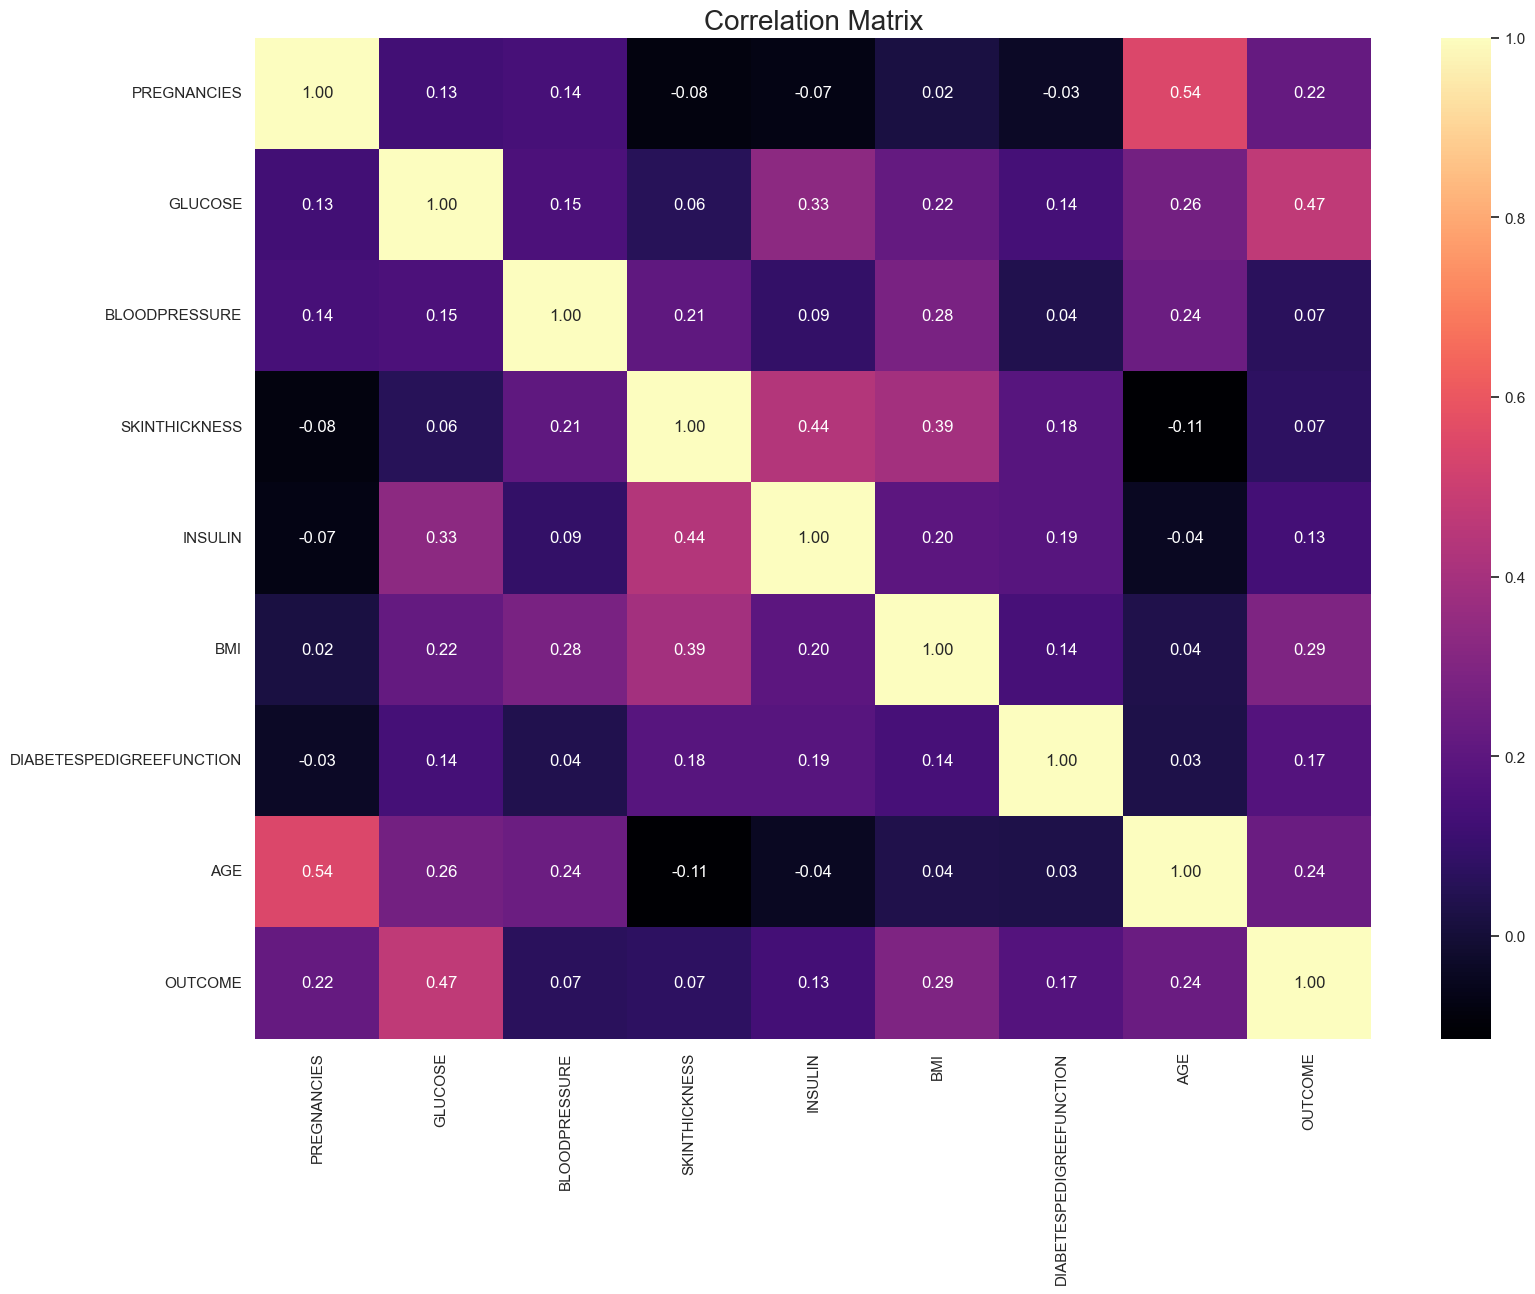

In [177]:
def corr_analysis(df,plot=False):
    corr =df.corr()
    # Korelasyon Matrisi
    f, ax = plt.subplots(figsize=[18, 13])
    sns.heatmap(corr, annot=True, fmt=".2f", ax=ax, cmap="magma")
    ax.set_title("Correlation Matrix", fontsize=20)
    plt.show()

corr_analysis(df, True)

### Base Model

In [178]:

y = df["OUTCOME"]
x = df.drop("OUTCOME", axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y, train_size=0.7, test_size=0.3, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


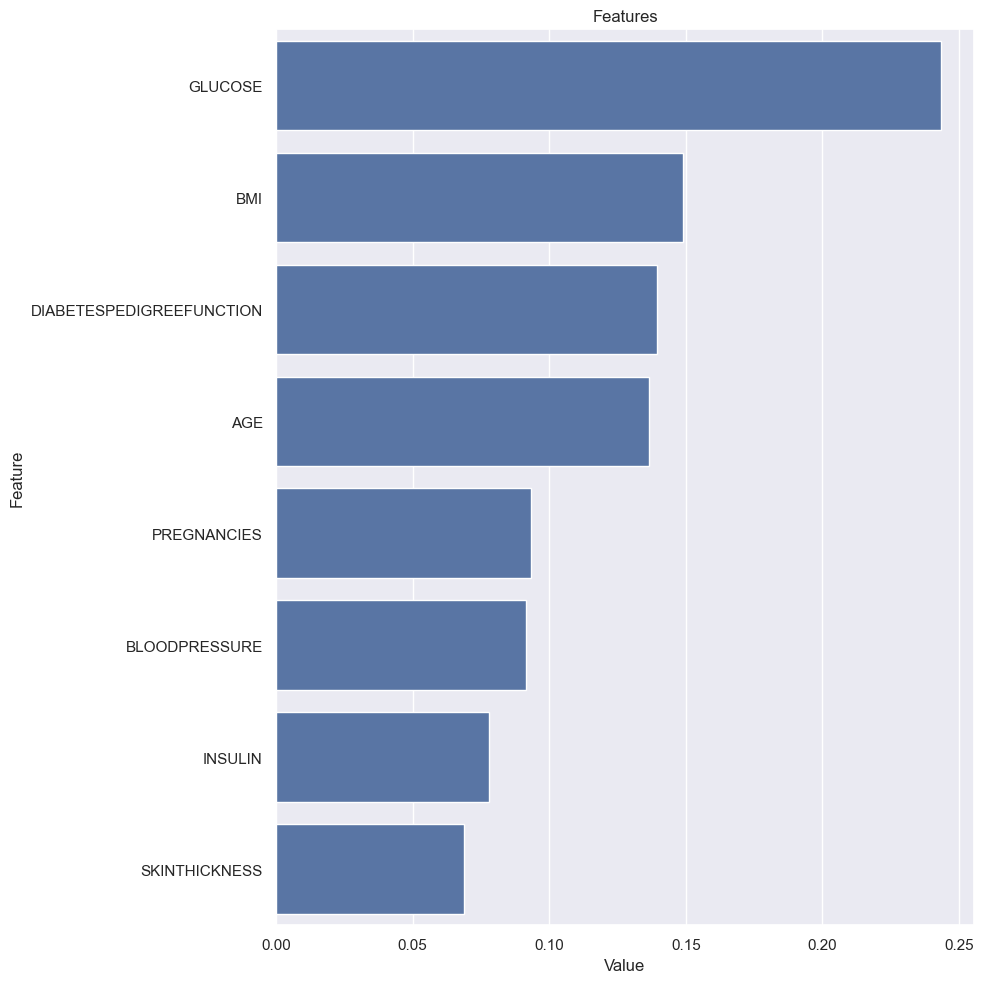

In [179]:
def plot_importance(model, features, num=len(x), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, x)

# Feature Engineering

### Missing Value Analysis

In [180]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
# Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .

zero_cols = [col for col in df.columns if df[col].min() == 0 and col not in ["PREGNANCIES", "OUTCOME"]]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [181]:
# Filling unlogical zeros with nans
df[zero_cols] = df[zero_cols].apply(lambda col: np.where(col == 0, np.nan, col))
df.head()
df.isnull().sum()

PREGNANCIES                   0
GLUCOSE                       5
BLOODPRESSURE                35
SKINTHICKNESS               227
INSULIN                     374
BMI                          11
DIABETESPEDIGREEFUNCTION      0
AGE                           0
OUTCOME                       0
dtype: int64

In [182]:
def missing_values_table(df,return_na_col_names=False):
    n_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[n_cols].isnull().sum().sort_values(ascending=False)
    ratio = (100 * n_miss / df.shape[0]).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if return_na_col_names:
        return n_cols

na_columns = missing_values_table(df, return_na_col_names=True)

               n_miss  ratio
INSULIN           374 48.700
SKINTHICKNESS     227 29.560
BLOODPRESSURE      35  4.560
BMI                11  1.430
GLUCOSE             5  0.650


In [183]:
def missing_vs_target(df,target, na_cols):
    temp_df = df.copy()
    for col in na_cols:
        temp_df[col+"_NA_FLAG"] = np.where(temp_df[col].isna(), 1, 0)
    
    na_flags = temp_df.loc[:,temp_df.columns.str.contains("_NA_")].columns
    
    for col in na_flags:
        # print(pd.DataFrame({
        #     "TARGET_MEAN": temp_df.groupby(col)[target].mean(),
        #     "COUNT": temp_df.groupby(col)[target].count()
        #     }), end='\n\n')
        # OR
        print(pd.concat([
        temp_df.groupby(col).agg({target: "mean"}).rename(columns={target: "TARGET_MEAN"}),
        temp_df.groupby(col).agg({target: "count"}).rename(columns={target: "COUNT"})
    ], axis=1), end='\n\n')

missing_vs_target(df, "OUTCOME", na_columns)


                 TARGET_MEAN  COUNT
GLUCOSE_NA_FLAG                    
0                      0.349    763
1                      0.400      5

                       TARGET_MEAN  COUNT
BLOODPRESSURE_NA_FLAG                    
0                            0.344    733
1                            0.457     35

                       TARGET_MEAN  COUNT
SKINTHICKNESS_NA_FLAG                    
0                            0.333    541
1                            0.388    227

                 TARGET_MEAN  COUNT
INSULIN_NA_FLAG                    
0                      0.330    394
1                      0.369    374

             TARGET_MEAN  COUNT
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11



In [184]:
# Filling missing values

for col in zero_cols:
    df.loc[df[col].isnull(), col] = df[col].median()


df.isna().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

### Outliers Analysis

In [185]:
def outlier_thresholds(df, col_name, q1_rate=0.05, q3_rate = 0.95):
    q1_value = df[col_name].quantile(q1_rate)
    q3_value = df[col_name].quantile(q3_rate)

    inter_quartile_range = q3_value - q1_value

    upper = q3_value + 1.5 * inter_quartile_range
    lower = q1_value - 1.5 * inter_quartile_range

    return lower, upper


lower_limit, upper_limit = outlier_thresholds(df, "BLOODPRESSURE")
print(lower_limit, upper_limit, sep=" ----> ")

-5.0 ----> 147.0


In [186]:
def check_outlier(df,col_name,q1_rate=0.05,q3_rate=0.95):
    lower_limit, upper_limit = outlier_thresholds(df,col_name, q1_rate, q3_rate)

    return df[(df[col_name] < lower_limit) | (df[col_name] > upper_limit)].any(axis=None).astype(bool)

check_outlier(df, "INSULIN")

np.True_

In [187]:
def replace_with_thresholds(df,col_name,q1=0.05,q3=0.95):
    lower_limit, upper_limit = outlier_thresholds(df, col, q1, q3)
    df.loc[(df[col_name] < lower_limit), col_name] = lower_limit
    df.loc[(df[col_name] > upper_limit), col_name] = upper_limit
    
    

In [188]:
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS True
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False
OUTCOME False


In [189]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


### Feature Extraction

In [190]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması

df.loc[(df["AGE"] >= 21) & (df["AGE"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df.AGE >= 50), "NEW_AGE_CAT"] = "senior"
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature


In [191]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez

import sys

df["NEW_BMI_CAT"] = pd.cut(df.BMI, bins=[0,18.5,24.9,29.9,sys.maxsize], labels=["underweight", "healthy", "overweight", "obese"])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese


In [192]:
df["NEW_GLUCOSE_CAT"] = pd.cut(df.GLUCOSE, bins=[0, 140, 200, 300], labels=["normal", "prediebetes", "diabetes"])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal


In [193]:
df.loc[(df.NEW_AGE_CAT=="senior") & (df.NEW_BMI_CAT == "healthy"), "NEW_AGE_BMI_NOM"] = "healthy_senior"
df.loc[(df.NEW_AGE_CAT == "mature") & (df.NEW_BMI_CAT == "healthy"), "NEW_AGE_BMI_NOM"] = "healthy_mature"

df.loc[(df.NEW_AGE_CAT=="senior") & (df.NEW_BMI_CAT == "overweight"), "NEW_AGE_BMI_NOM"] = "overweight_senior"
df.loc[(df.NEW_AGE_CAT == "mature") & (df.NEW_BMI_CAT == "overweight"), "NEW_AGE_BMI_NOM"] = "overweight_mature"

df.loc[(df.NEW_AGE_CAT=="senior") & (df.NEW_BMI_CAT == "obese"), "NEW_AGE_BMI_NOM"] = "obese_senior"
df.loc[(df.NEW_AGE_CAT == "mature") & (df.NEW_BMI_CAT == "obese"), "NEW_AGE_BMI_NOM"] = "obese_mature"

df.loc[(df.NEW_AGE_CAT=="senior") & (df.NEW_BMI_CAT == "underweight"), "NEW_AGE_BMI_NOM"] = "underweight_senior"
df.loc[(df.NEW_AGE_CAT == "mature") & (df.NEW_BMI_CAT == "underweight"), "NEW_AGE_BMI_NOM"] = "underweight_mature"
df.head(10)

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature
5,5,116.000,74.000,29.000,125.000,25.600,0.201,30,0,mature,overweight,normal,overweight_mature
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1,mature,obese,normal,obese_mature
7,10,115.000,72.000,29.000,125.000,35.300,0.134,29,0,mature,obese,normal,obese_mature
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1,senior,obese,prediebetes,obese_senior
9,8,125.000,96.000,29.000,125.000,32.300,0.232,54,1,senior,obese,normal,obese_senior


In [194]:
df.loc[(df.GLUCOSE < 70) & (df.AGE >=21) & (df.AGE < 50), "NEW_GLUCOSE_AGE_NOM"] = "low_mature"
df.loc[(df.GLUCOSE < 70) & (df.AGE >= 50), "NEW_GLUCOSE_AGE_NOM"] = "low_senior"

df.loc[(df.GLUCOSE >=70) & (df.GLUCOSE < 100) & (df.AGE >=21) & (df.AGE < 50), "NEW_GLUCOSE_AGE_NOM"] = "normal_mature"
df.loc[(df.GLUCOSE >=70) & (df.GLUCOSE < 100) & (df.AGE >= 50), "NEW_GLUCOSE_AGE_NOM"] = "normal_senior"

df.loc[(df.GLUCOSE >=100) & (df.GLUCOSE <= 125) &  (df.AGE >=21) & (df.AGE < 50), "NEW_GLUCOSE_AGE_NOM"] = "hidden_mature"
df.loc[(df.GLUCOSE >=100) & (df.GLUCOSE <= 125) &  (df.AGE >= 50), "NEW_GLUCOSE_AGE_NOM"] = "hidden_senior"

df.loc[(df.GLUCOSE >125) &  (df.AGE >=21) & (df.AGE < 50), "NEW_GLUCOSE_AGE_NOM"] = "high_mature"
df.loc[(df.GLUCOSE >125) &  (df.AGE >= 50), "NEW_GLUCOSE_AGE_NOM"] = "high_senior"

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior,high_senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature,normal_mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature,high_mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature,normal_mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature,high_mature


In [195]:

# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(df, col_name="INSULIN"):
    if 16 <= df[col_name] <= 166:
        return "normal"
    
    return "abnormal"


df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM,NEW_INSULIN_SCORE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior,high_senior,normal
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature,normal_mature,normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature,high_mature,normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature,normal_mature,normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature,high_mature,abnormal


In [196]:
df["NEW_GLUCOSE*INSULIN"] = df["GLUCOSE"] * df["INSULIN"]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior,high_senior,normal,18500.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature,normal_mature,normal,10625.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature,high_mature,normal,22875.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature,normal_mature,normal,8366.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature,high_mature,abnormal,23016.000


In [197]:
# Keep zeros in mind
df["NEW_GLUCOSE*PREGNANCIES"] = df["GLUCOSE"] * (1 + df["PREGNANCIES"])
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior,high_senior,normal,18500.000,1036.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature,normal_mature,normal,10625.000,170.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature,high_mature,normal,22875.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature,normal_mature,normal,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature,high_mature,abnormal,23016.000,137.000


### Encoding

In [198]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,obese,prediebetes,obese_senior,high_senior,normal,18500.000,1036.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,overweight,normal,overweight_mature,normal_mature,normal,10625.000,170.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,healthy,prediebetes,healthy_mature,high_mature,normal,22875.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,overweight,normal,overweight_mature,normal_mature,normal,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,obese,normal,obese_mature,high_mature,abnormal,23016.000,137.000


In [199]:
cat_cols, num_cols, cat_but_cat = grab_columns(df)
cat_cols.remove("OUTCOME")


def label_encoder(df, binary_col):
    label_encoder = LabelEncoder()
    df[binary_col] = label_encoder.fit_transform(df[binary_col])
    return df

binary_cols = [col for col in df.columns if df[col].dtype in ["object", "category"] and df[col].nunique() == 2]
binary_cols

for col in binary_cols:
    label_encoder(df, col)


df.head()


Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 1


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI_CAT,NEW_GLUCOSE_CAT,NEW_AGE_BMI_NOM,NEW_GLUCOSE_AGE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,obese,1,obese_senior,high_senior,1,18500.000,1036.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,overweight,0,overweight_mature,normal_mature,1,10625.000,170.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,healthy,1,healthy_mature,high_mature,1,22875.000,1647.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,overweight,0,overweight_mature,normal_mature,1,8366.000,178.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,obese,0,obese_mature,high_mature,0,23016.000,137.000


In [200]:
def one_hot_encoder(df, ohe_cols, drop_first=False):
    return  pd.get_dummies(df, columns=ohe_cols, drop_first=drop_first).astype(int)


ohe_cols = [col for col in df.columns if df[col].dtype in ["object", "category"] and df[col].nunique() > 2 and col != "OUTCOME"]

df = one_hot_encoder(df, ohe_cols, True)

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_BMI_CAT_healthy,NEW_BMI_CAT_overweight,NEW_BMI_CAT_obese,NEW_AGE_BMI_NOM_healthy_senior,NEW_AGE_BMI_NOM_obese_mature,NEW_AGE_BMI_NOM_obese_senior,NEW_AGE_BMI_NOM_overweight_mature,NEW_AGE_BMI_NOM_overweight_senior,NEW_AGE_BMI_NOM_underweight_mature,NEW_GLUCOSE_AGE_NOM_hidden_senior,NEW_GLUCOSE_AGE_NOM_high_mature,NEW_GLUCOSE_AGE_NOM_high_senior,NEW_GLUCOSE_AGE_NOM_low_mature,NEW_GLUCOSE_AGE_NOM_low_senior,NEW_GLUCOSE_AGE_NOM_normal_mature,NEW_GLUCOSE_AGE_NOM_normal_senior
0,6,148,72,35,125,33,0,50,1,1,1,1,18500,1036,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,85,66,29,125,26,0,31,0,0,0,1,10625,170,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,8,183,64,29,125,23,0,32,1,0,1,1,22875,1647,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,89,66,23,94,28,0,21,0,0,0,1,8366,178,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,137,40,35,168,43,2,33,1,0,0,0,23016,137,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0


### Scaling

In [201]:
scaler  = StandardScaler()

cat_cols, num_cols, cat_but_car = grab_columns(df)

df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

Observations: 768
Variables: 30
cat_cols: 21
num_cols: 9
cat_but_car: 0
num_but_cat: 21


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_BMI_CAT_healthy,NEW_BMI_CAT_overweight,NEW_BMI_CAT_obese,NEW_AGE_BMI_NOM_healthy_senior,NEW_AGE_BMI_NOM_obese_mature,NEW_AGE_BMI_NOM_obese_senior,NEW_AGE_BMI_NOM_overweight_mature,NEW_AGE_BMI_NOM_overweight_senior,NEW_AGE_BMI_NOM_underweight_mature,NEW_GLUCOSE_AGE_NOM_hidden_senior,NEW_GLUCOSE_AGE_NOM_high_mature,NEW_GLUCOSE_AGE_NOM_high_senior,NEW_GLUCOSE_AGE_NOM_low_mature,NEW_GLUCOSE_AGE_NOM_low_senior,NEW_GLUCOSE_AGE_NOM_normal_mature,NEW_GLUCOSE_AGE_NOM_normal_senior
0,0.640,0.866,-0.032,0.680,-0.183,0.145,0,1.426,1,1,1,1,0.024,0.914,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.874,0,-0.191,0,0,0,1,-0.503,-0.913,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.310,0,-0.106,1,0,1,1,0.317,2.203,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.583,0,-1.042,0,0,0,1,-0.654,-0.896,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,-1.142,0.504,-2.679,0.680,0.331,1.599,2,-0.020,1,0,0,0,0.326,-0.982,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0


### Model

In [202]:
print(df.head())

y = df["OUTCOME"]
X = df.drop(columns="OUTCOME")

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  DIABETESPEDIGREEFUNCTION    AGE  OUTCOME  NEW_AGE_CAT  NEW_GLUCOSE_CAT  NEW_INSULIN_SCORE  NEW_GLUCOSE*INSULIN  NEW_GLUCOSE*PREGNANCIES  NEW_BMI_CAT_healthy  NEW_BMI_CAT_overweight  NEW_BMI_CAT_obese  NEW_AGE_BMI_NOM_healthy_senior  NEW_AGE_BMI_NOM_obese_mature  NEW_AGE_BMI_NOM_obese_senior  NEW_AGE_BMI_NOM_overweight_mature  NEW_AGE_BMI_NOM_overweight_senior  NEW_AGE_BMI_NOM_underweight_mature  \
0        0.640    0.866         -0.032          0.680   -0.183  0.145                         0  1.426        1            1                1                  1                0.024                    0.914                    0                       0                  1                               0                             0                             1                                  0                                  0                                   0   
1       -0.845   -1.205         -0.528         -0.011   

    Value                             Feature
1   0.154                             GLUCOSE
11  0.146                 NEW_GLUCOSE*INSULIN
12  0.108             NEW_GLUCOSE*PREGNANCIES
7   0.096                                 AGE
5   0.089                                 BMI
2   0.066                       BLOODPRESSURE
0   0.065                         PREGNANCIES
3   0.057                       SKINTHICKNESS
4   0.054                             INSULIN
9   0.035                     NEW_GLUCOSE_CAT
27  0.022   NEW_GLUCOSE_AGE_NOM_normal_mature
23  0.018     NEW_GLUCOSE_AGE_NOM_high_mature
6   0.017            DIABETESPEDIGREEFUNCTION
15  0.013                   NEW_BMI_CAT_obese
17  0.008        NEW_AGE_BMI_NOM_obese_mature
10  0.008                   NEW_INSULIN_SCORE
14  0.007              NEW_BMI_CAT_overweight
13  0.007                 NEW_BMI_CAT_healthy
19  0.006   NEW_AGE_BMI_NOM_overweight_mature
8   0.005                         NEW_AGE_CAT
18  0.005        NEW_AGE_BMI_NOM_o

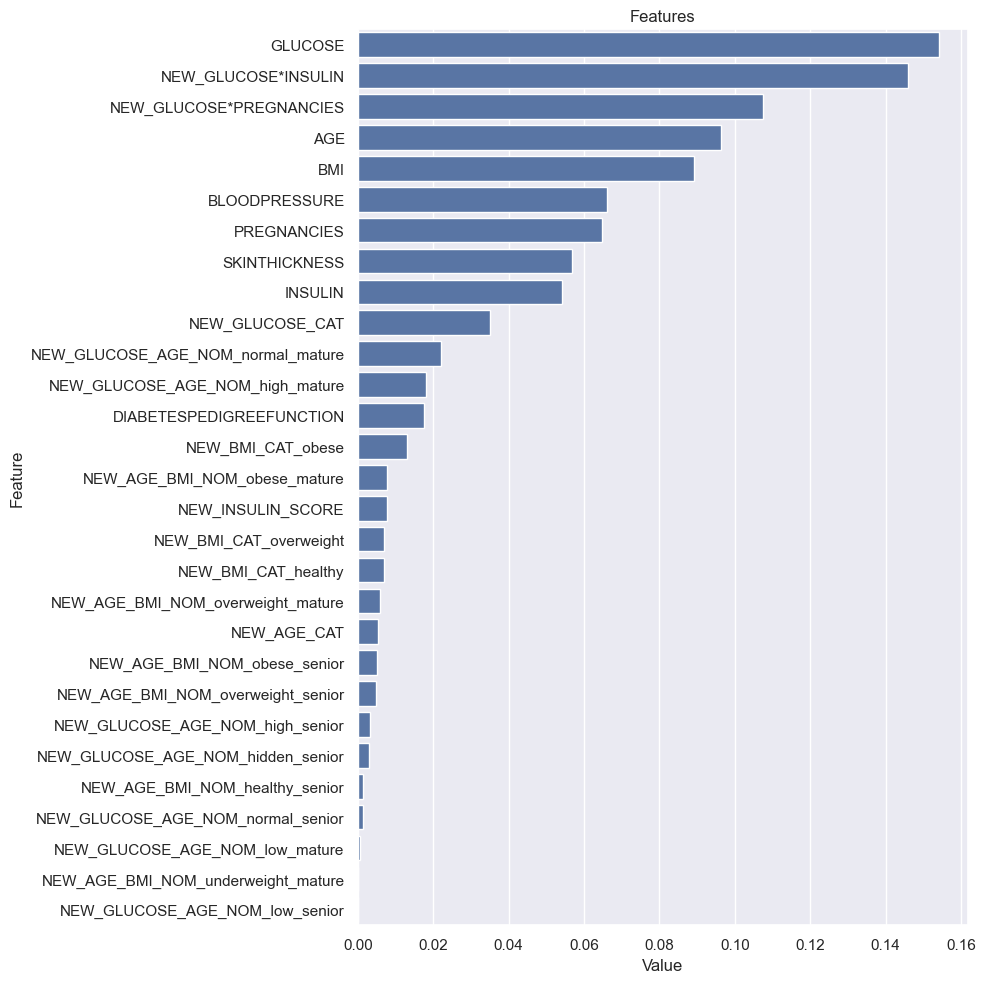

In [203]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)

In [ ]:
# Base Model
Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75

# Featured Engineered Model
Accuracy: 0.77
Recall: 0.71
Precision: 0.6
F1: 0.65
Auc: 0.76